# Incorporating Human Feedback into Quality Diversity for Diversified Text-to-Image Generation

*This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read.*


Foundation models such as large language models (LLMs) and text-to-image generation models ([Stable Diffusion](https://arxiv.org/abs/2112.10752), [DALL·E](https://openai.com/dall-e-3), etc.) in effect compress vast archives of human knowledge into powerful and flexible tools, serving as a foundation for down-stream applications. One mechanism to build upon such foundational knowledge is reinforcement learning from human feedback (RLHF), which can make models both easier to use (by aligning them to human instructions), and more competent (by improving their capabilities based on human preferences).

RLHF is a relatively new paradigm, and its deployments often follow the relatively narrow recipe of maximizing a learned reward model of averaged human preferences over model responses. However, there are drawbacks when it is used to optimize for average human preferences, especially in generative tasks that demand diverse and creative model responses. On the other hand, Quality Diversity (QD) algorithms excel at identifying diverse and high-quality solutions but often rely on manually-crafted diversity metrics, as shown in previous examples, such as [DQD](https://docs.pyribs.org/en/stable/tutorials/tom_cruise_dqd.html). 

In this work, we introduce [Quality Diversity through Human Feedback (QDHF)](https://liding.info/qdhf/), which aims to broaden the RLHF recipe to include optimizing for interesting diversity among responses, which is of practical importance for many creative applications such as text-to-image generation. Such increased diversity can also improve optimization for complex and open-ended tasks (through improved exploration), personalization (serving individual rather than average human preference), and fairness (to offset algorithmic biases in gender, ethnicity, and more). 

<br>

![Overview of QDHF.](_static/qdhf-method.png)

<br>

Our main idea is to derive distinct representations of what humans find interestingly different, and use such diversity representations to support optimization. An overview of our method is shown in the diagram above. 

In this tutorial, we implement QDHF for the latent space illumination (LSI) experiment. LSI uses QD algorithms to search for a diverse collection of images in a GAN’s latent space, which has been introduced in the previous [DQD tutorial](https://docs.pyribs.org/en/stable/tutorials/tom_cruise_dqd.html). However, instead of generating images of a celebrity, this LSI pipeline uses [Stable Diffusion](https://arxiv.org/abs/2112.10752) to generate diverse images according to a given text prompt, like the one shown below (*prompt: an image of a bear in a national park*).

![QDHF example](_static/qdhf-example.jpg)

Another difference in this tutorial is that, QDHF uses human feedback to derive meaningful diversity metrics, not by manually specifying attributes such as age and hair length. We use a preference model, [DreamSim](https://dreamsim-nights.github.io/), which is trained on a dataset of human judgment of similarity between images, to source feedback in QDHF optimization. Specifically, we implement QDHF with Map-Elites, and run it with the Stable Diffusion+CLIP pipeline.

*This tutorial assumes that you are familiar with Latent Space Illumination (LSI). If you are not yet familiar with it, we recommend reviewing the DQD tutorial which generates Tom Cruise Images and LSI MNIST tutorial which generates diverse MNIST digits.*

## Setup

Since Stable Diffusion, CLIP, and DreamSim are fairly large models, you will need a GPU to run this tutorial. On Colab, activate the GPU by clicking "Runtime" in the toolbar at the top. Then, click "Change Runtime Type", and select "GPU".

Below, we check what GPU has been provided. The possible GPUs (at the time of writing) are as follows; factory reset the runtime if you do not have a desired GPU.

* V100 = Excellent (*Available only for Colab Pro users*)
* P100 = Very Good
* T4 = Good (*preferred*)
* K80 = Meh
* P4 = (*Not Recommended*)

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-15c34789-f589-ae67-9e39-9ea535cf0b0b)


Now, we install various libraries, including pyribs, CLIP, Stable Diffusion, and DreamSim. This cell will take around 5-10 minutes to run since it involves downloading multiple large files.

In [2]:
%pip install ribs torch torchvision git+https://github.com/openai/CLIP shapely alive_progress dreamsim diffusers accelerate numpy matplotlib

In [3]:
import time
import numpy as np
from alive_progress import alive_bar

Let's first set up CUDA for PyTorch. We use float16 to save GPU memories for large models.

In [4]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print("Torch device:", DEVICE)

# Use float16 for GPU, float32 for CPU.
TORCH_DTYPE = torch.float16 if torch.cuda.is_available() else torch.float32
print("Torch dtype:", TORCH_DTYPE)

Torch device: cuda
Torch dtype: torch.float16


## Preliminaries: CLIP, Stable Diffusion, and DreamSim

Below we set up CLIP, Stable Diffusion, and DreamSim. The code for these models is adopted from the [DQD tutorial](https://docs.pyribs.org/en/stable/tutorials/tom_cruise_dqd.html), the [DreamSim demo](https://colab.research.google.com/drive/1taEOMzFE9g81D9AwH27Uhy2U82tQGAVI?usp=sharing), and the [Hugging Face Stable Diffusion example](https://huggingface.co/stabilityai/stable-diffusion-2-1). Each cell may take around 3 minutes to run since it involves downloading multiple large files.

*Since this section is focused on the LSI pipeline rather than on pyribs, feel free to skim past and come back to it later.*

### CLIP for Connecting Text and Images

In [5]:
import clip

# This tutorial uses ViT-B/16 for faster inference, feel free to use other checkpoints.
CLIP_MODEL, CLIP_PREPROCESS = clip.load("ViT-B/32", device=DEVICE)
CLIP_MODEL.eval()
for p in CLIP_MODEL.parameters():
    p.requires_grad_(False)


def compute_clip_scores(imgs, text, return_clip_features=False):
    """Function to compute CLIP scores for a batch of images and a given text prompt."""
    img_tensor = torch.stack([CLIP_PREPROCESS(img) for img in imgs]).to(DEVICE)
    tokenized_text = clip.tokenize([text]).to(DEVICE)
    img_logits, _text_logits = CLIP_MODEL(img_tensor, tokenized_text)
    img_logits = img_logits.detach().cpu().numpy().astype(np.float32)[:, 0]
    img_logits = 1 / img_logits * 100
    # Remap the objective from minimizing [0, 10] to maximizing [0, 100]
    img_logits = (10.0 - img_logits) * 10.0

    if return_clip_features:
        clip_features = CLIP_MODEL.encode_image(img_tensor).to(TORCH_DTYPE)
        return img_logits, clip_features
    else:
        return img_logits

### DreamSim for Simulating Human Feedback

In [6]:
from dreamsim import dreamsim

DREAMSIM_MODEL, DREAMSIM_PREPROCESS = dreamsim(
    pretrained=True, dreamsim_type="open_clip_vitb32", device=DEVICE
)

Using cached ./models


/home/liding_umass_edu/.local/lib/python3.11/site-packages/peft/tuners/lora.py:143: UserWarning: fan_in_fan_out is set to True but the target module is not a Conv1D. Setting fan_in_fan_out to False.
  warnings.warn(


### Stable Diffusion for Generating Images
By default, we use the [`miniSD-diffusers` checkpoint](https://huggingface.co/lambdalabs/miniSD-diffusers), which generates images at 256x256 for faster inference and less GPU memory usage. Please switch to the `stable-diffusion-2-1-base` checkpoint to generate images with higher resolution and quality.

In [7]:
from diffusers import StableDiffusionPipeline

IMG_WIDTH = 256
IMG_HEIGHT = 256
SD_IN_HEIGHT = 32
SD_IN_WIDTH = 32
SD_CHECKPOINT = "lambdalabs/miniSD-diffusers"

# IMG_WIDTH = 512
# IMG_HEIGHT = 512
# SD_IN_HEIGHT = 64
# SD_IN_WIDTH = 64
# SD_CHECKPOINT = "stabilityai/stable-diffusion-2-1-base"

BATCH_SIZE = 4
SD_IN_CHANNELS = 4
SD_IN_SHAPE = (
    BATCH_SIZE,
    SD_IN_CHANNELS,
    SD_IN_HEIGHT,
    SD_IN_WIDTH,
)

SDPIPE = StableDiffusionPipeline.from_pretrained(
    SD_CHECKPOINT,
    torch_dtype=TORCH_DTYPE,
    safety_checker=None,  # for faster inference
    requires_safety_checker=False,
)

SDPIPE.set_progress_bar_config(disable=True)
SDPIPE = SDPIPE.to(DEVICE)

/home/liding_umass_edu/.local/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/liding_umass_edu/.local/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### Helper Functions to Compute Objectives and Measures

In [8]:
def compute_diversity_measures(clip_features, dis_embed_model):
    with torch.no_grad():
        measures = dis_embed_model(clip_features).detach().cpu().numpy()
    return measures


def evaluate_lsi(
    latents,
    prompt,
    return_features=False,
    dis_embed_model=None,
):
    """Function to evaluate the objective of LSI for a batch of latents and a given text prompt."""

    images = SDPIPE(
        prompt,
        num_images_per_prompt=latents.shape[0],
        latents=latents,
        # num_inference_steps=1,  # for testing
    ).images

    objs, clip_features = compute_clip_scores(
        images,
        prompt,
        return_clip_features=True,
    )

    images = torch.cat([DREAMSIM_PREPROCESS(img) for img in images]).to(DEVICE)
    dreamsim_features = DREAMSIM_MODEL.embed(images)

    if dis_embed_model is not None:
        measures = compute_diversity_measures(clip_features, dis_embed_model)
    else:
        measures = None

    if return_features:
        return objs, measures, clip_features, dreamsim_features
    else:
        return objs, measures

## Train Diversity Metrics through Constrastive Learning

Next, we define a embedding model to compute the diversity representations, which are trained through constrastive learning from human feedback. The DreamSim model is pre-trained on the human feedback data, so we will use it as the source of feedback here. We calculate the cosine similarity of DreamSim features, and use that as the ground truth to train the embedding model.

The embedding model projects the image features onto a low-dimensional latent space, where each dimension represents a numeric diversity metric. An intuitive example is that the model may learn "object size" as a metric, where low values mean the object is small and high values mean it is large.


In [9]:
from torch import nn


class DisEmbed(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=latent_dim),
        )

    def forward(self, x):
        x = self.enc(x)
        return x

    def calc_dis(self, x1, x2):
        x1 = self.forward(x1)
        x2 = self.forward(x2)
        return torch.sum(torch.square(x1 - x2), -1)

    def triplet_delta_dis(self, ref, x1, x2):
        x1 = self.forward(x1)
        x2 = self.forward(x2)
        ref = self.forward(ref)
        return torch.sum(torch.square(ref - x1), -1) - torch.sum(
            torch.square(ref - x2), -1
        )


def fit_dis_embed(inputs, gt_measures, latent_dim, batch_size=32):
    t = time.time()
    model = DisEmbed(input_dim=inputs.shape[-1], latent_dim=latent_dim)
    model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = lambda y, delta_dis: torch.max(
        torch.tensor([0.0]).to(DEVICE), 0.05 - y * delta_dis
    ).mean()
    n_pref_data = inputs.shape[0]
    ref = inputs[:, 0]
    x1 = inputs[:, 1]
    x2 = inputs[:, 2]

    n_train = int(n_pref_data * 0.75)
    n_val = n_pref_data - n_train

    ref_train = ref[:n_train]
    x1_train = x1[:n_train]
    x2_train = x2[:n_train]
    ref_val = ref[n_train:]
    x1_val = x1[n_train:]
    x2_val = x2[n_train:]

    n_iters_per_epoch = max((n_train) // batch_size, 1)

    ref_gt_measures = gt_measures[:, 0]
    x1_gt_measures = gt_measures[:, 1]
    x2_gt_measures = gt_measures[:, 2]
    ref_gt_train = ref_gt_measures[:n_train]
    x1_gt_train = x1_gt_measures[:n_train]
    x2_gt_train = x2_gt_measures[:n_train]
    ref_gt_val = ref_gt_measures[n_train:]
    x1_gt_val = x1_gt_measures[n_train:]
    x2_gt_val = x2_gt_measures[n_train:]

    val_acc = []
    for epoch in range(200):
        for _ in range(n_iters_per_epoch):
            idx = np.random.choice(n_train, batch_size)
            batch_ref = ref_train[idx].float()
            batch1 = x1_train[idx].float()
            batch2 = x2_train[idx].float()

            optimizer.zero_grad()
            delta_dis = model.triplet_delta_dis(batch_ref, batch1, batch2)
            gt_dis = torch.nn.functional.cosine_similarity(
                ref_gt_train[idx], x2_gt_train[idx], dim=-1
            ) - torch.nn.functional.cosine_similarity(
                ref_gt_train[idx], x1_gt_train[idx], dim=-1
            )
            gt = (gt_dis > 0).to(TORCH_DTYPE) * 2 - 1

            loss = loss_fn(gt, delta_dis)
            loss.backward()
            optimizer.step()

        # Evaluate.
        n_correct = 0
        n_total = 0
        with torch.no_grad():
            idx = np.arange(n_val)
            batch_ref = ref_val[idx].float()
            batch1 = x1_val[idx].float()
            batch2 = x2_val[idx].float()
            delta_dis = model.triplet_delta_dis(batch_ref, batch1, batch2)
            pred = delta_dis > 0
            gt_dis = torch.nn.functional.cosine_similarity(
                ref_gt_val[idx], x2_gt_val[idx], dim=-1
            ) - torch.nn.functional.cosine_similarity(
                ref_gt_val[idx], x1_gt_val[idx], dim=-1
            )
            gt = gt_dis > 0
            n_correct += (pred == gt).sum().item()
            n_total += len(idx)

        acc = n_correct / n_total
        val_acc.append(acc)

        if epoch > 10 and np.mean(val_acc[-10:]) < np.mean(val_acc[-11:-1]):
            break

    print(
        f"{np.round(time.time()- t, 1)}s ({epoch+1} epochs) | DisEmbed (n={n_pref_data}) fitted with val acc.: {acc}"
    )

    return model.to(TORCH_DTYPE), acc

## QDHF with pyribs

To use QDHF to generate diverse collections of images, we will use the MAP-Elites algorithm, where the diversity metrics are progressively trained and fine-tuned during optimization. 

### Optimizer

First, we create the [`GridArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html). The archive is 20x20 and stores Stable Diffusion latent vectors. The dimensions of vectors are (BATCH, 4, H, W) where H=W=32 if you are generating 256x256 images with `miniSD`, or 64 for 512x512 images with `stable-diffusion-2-1-base`. 

The optimizer is a [`Scheduler`](https://docs.pyribs.org/en/latest/api/ribs.schedulers.Scheduler.html) class that controls how the emitters interact with the archive and result archive. More details are already covered in the previous [DQD tutorial](https://docs.pyribs.org/en/stable/tutorials/tom_cruise_dqd.html). 

In [10]:
from ribs.archives import GridArchive
from ribs.schedulers import Scheduler
from ribs.emitters import GaussianEmitter

GRID_SIZE = (20, 20)
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

def tensor_to_list(tensor):
    sols = tensor.detach().cpu().numpy().astype(np.float32)
    return sols.reshape(sols.shape[0], -1)


def list_to_tensor(list_):
    sols = np.array(list_).reshape(
        len(list_), 4, SD_IN_HEIGHT, SD_IN_WIDTH
    )  # hard-coded for now
    return torch.tensor(sols, dtype=TORCH_DTYPE, device=DEVICE)


def create_optimizer(
    sols,
    objs,
    clip_features,
    dis_embed_model,
    seed=None,
):
    num_emitters = 1

    measures = compute_diversity_measures(clip_features, dis_embed_model)
    archive_bounds = np.array(
        [np.quantile(measures, 0.01, axis=0), np.quantile(measures, 0.99, axis=0)]
    ).T

    sols = tensor_to_list(sols)
    archive = GridArchive(
        solution_dim=len(sols[0]), dims=GRID_SIZE, ranges=archive_bounds, seed=SEED
    )

    # Add each solution to the archive.
    archive.add(sols, objs, measures)

    # Create emitters. Each emitter needs a different seed, so that they do not
    # all do the same thing.
    init_sols = archive.sample_elites(BATCH_SIZE)["solution"]
    emitter_seeds = (
        [None] * num_emitters
        if seed is None
        else list(range(seed, seed + num_emitters))
    )
    emitters = [
        GaussianEmitter(
            archive=archive,
            sigma=0.1,
            initial_solutions=init_sols,
            batch_size=BATCH_SIZE,
            seed=s,
        )
        for s in emitter_seeds
    ]
    return archive, Scheduler(archive, emitters)

### Visualization

We define a simple helper function to visualize the grid archive as a heatmap.

In [11]:
import matplotlib.pyplot as plt
from ribs.visualize import grid_archive_heatmap


def save_heatmap(archive, heatmap_path):
    """Saves a heatmap of the archive to the given path.

    Args:
        archive (GridArchive or CVTArchive): The archive to save.
        heatmap_path: Image path for the heatmap.
    """
    fig = plt.figure(figsize=(8, 6), dpi=300)
    grid_archive_heatmap(archive, vmin=0.0, vmax=100.0)
    plt.tight_layout()
    fig.savefig(heatmap_path)

    plt.clf()
    plt.close(fig)

## LSI with QDHF

Having set up the necessary components above, we now run QDHF to search for images of a given prompt. The default prompt is "an astronaut riding a horse on mars".

### Training

The execution loop is similar to the experiments in previous tutorials. The main difference is that when the iteration is in `update_schedule`, we will update the QD archive by fine-tuning the diversity metrics and add current solutions to the archive again with regard to their updated diversity measures.

The total number of iterations is set to be 200, and it should take ~30min to run on a GPU.

In [12]:
# Change here for whatever you like to generate.
prompt = "an astronaut riding a horse on mars"

INIT_POP = 200  # initial population

TOTAL_ITERS = 200  # total number of iterations
update_schedule = [1, 21, 51, 101]  # when to update the archive
n_pref_data = 1000  # number of preference used in each update

archive = None
best = 0.0
non_logging_time = 0.0
with alive_bar(TOTAL_ITERS, force_tty=True) as progress:
    for itr in range(1, TOTAL_ITERS + 1):
        itr_start = time.time()

        # Update archive and optimizer if needed.
        if itr in update_schedule:
            if archive is None:
                print("Initializing archive and diversity representations.")

                all_sols = []
                all_clip_features = []
                all_dreamsim_features = []
                all_objs = []

                # Sample random solutions and get judgment on similarity.
                n_batches = INIT_POP // BATCH_SIZE
                for _ in range(n_batches):
                    sols = torch.randn(SD_IN_SHAPE, device=DEVICE, dtype=TORCH_DTYPE)
                    objs, _, clip_features, dreamsim_features = evaluate_lsi(
                        sols, prompt, return_features=True
                    )
                    all_sols.append(sols)
                    all_clip_features.append(clip_features)
                    all_dreamsim_features.append(dreamsim_features)
                    all_objs.append(objs)
                all_sols = torch.concat(all_sols, dim=0)
                all_clip_features = torch.concat(all_clip_features, dim=0)
                all_dreamsim_features = torch.concat(all_dreamsim_features, dim=0)
                all_objs = np.concatenate(all_objs, axis=0)

                # Initialize the dis embed.
                dis_embed_data = []
                dis_embed_labels = []
                for _ in range(n_pref_data):
                    idx = np.random.choice(all_sols.shape[0], 3)
                    dis_embed_data.append(all_clip_features[idx])
                    dis_embed_labels.append(all_dreamsim_features[idx])
                dis_embed_data = torch.concat(dis_embed_data, dim=0)
                dis_embed_labels = torch.concat(dis_embed_labels, dim=0)
                dis_embed_data = dis_embed_data.reshape(n_pref_data, 3, -1)
                dis_embed_label = dis_embed_labels.reshape(n_pref_data, 3, -1)
                dis_embed_model, dis_embed_acc = fit_dis_embed(
                    dis_embed_data,
                    dis_embed_label,
                    latent_dim=2,
                )

            else:
                print("Updating archive and diversity representations.")

                # Get all the current solutions and collect feedback.
                all_sols = list_to_tensor(archive.data()["solution"])
                n_batches = np.ceil(len(all_sols) / BATCH_SIZE).astype(int)
                all_clip_features = []
                all_dreamsim_features = []
                all_objs = []
                for i in range(n_batches):
                    sols = all_sols[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
                    objs, _, clip_features, dreamsim_features = evaluate_lsi(
                        sols, prompt, return_features=True
                    )
                    all_clip_features.append(clip_features)
                    all_dreamsim_features.append(dreamsim_features)
                    all_objs.append(objs)
                all_clip_features = torch.concat(
                    all_clip_features, dim=0
                )  # n_pref_data * 3, dim
                all_dreamsim_features = torch.concat(all_dreamsim_features, dim=0)
                all_objs = np.concatenate(all_objs, axis=0)

                # Update the dis embed.
                additional_features = []
                additional_labels = []
                for _ in range(n_pref_data):
                    idx = np.random.choice(all_sols.shape[0], 3)
                    additional_features.append(all_clip_features[idx])
                    additional_labels.append(all_dreamsim_features[idx])
                additional_features = torch.concat(additional_features, dim=0)
                additional_labels = torch.concat(additional_labels, dim=0)
                additional_embed_data = additional_features.reshape(n_pref_data, 3, -1)
                additional_embed_label = additional_labels.reshape(n_pref_data, 3, -1)
                dis_embed_data = torch.concat(
                    (dis_embed_data, additional_embed_data), axis=0
                )
                dis_embed_label = torch.concat(
                    (dis_embed_label, additional_embed_label), axis=0
                )
                dis_embed_model, dis_embed_acc = fit_dis_embed(
                    dis_embed_data,
                    dis_embed_label,
                    latent_dim=2,
                )

            archive, optimizer = create_optimizer(
                all_sols,
                all_objs,
                all_clip_features,
                dis_embed_model,
                seed=SEED,
            )

        sols = optimizer.ask()
        sols = list_to_tensor(sols)
        objs, measures, clip_features, dreamsim_features = evaluate_lsi(
            sols, prompt, return_features=True, dis_embed_model=dis_embed_model
        )
        best = max(best, max(objs))
        optimizer.tell(objs, measures)

        non_logging_time += time.time() - itr_start
        progress()

        # Always save on the final iteration.
        final_itr = itr == TOTAL_ITERS

        # Update the summary statistics for the archive.
        qd_score, coverage = archive.stats.norm_qd_score, archive.stats.coverage

        print("QD score:", np.round(qd_score, 2), "Coverage:", coverage * 100)

on 0: Initializing archive and diversity representations.                       
on 0: 3.5s (15 epochs) | DisEmbed (n=1000) fitted with val acc.: 0.732          ▆█▆ 0/200 [0%] in 1:21 (~0s, 0.0/s) 
on 1: QD score: 23.7 Coverage: 32.75                                            
on 2: QD score: 24.06 Coverage: 33.25                                           
on 3: QD score: 24.24 Coverage: 33.5                                            
on 4: QD score: 24.77 Coverage: 34.25                                           
on 5: QD score: 25.5 Coverage: 35.25                                            
on 6: QD score: 25.68 Coverage: 35.5                                            
on 7: QD score: 26.05 Coverage: 36.0                                            
on 8: QD score: 26.41 Coverage: 36.5                                            
on 9: QD score: 26.76 Coverage: 37.0                                            
on 10: QD score: 26.94 Coverage: 37.25                                   

### Visualizing the Archive

Text(0, 0.5, 'Diversity Metric 2')

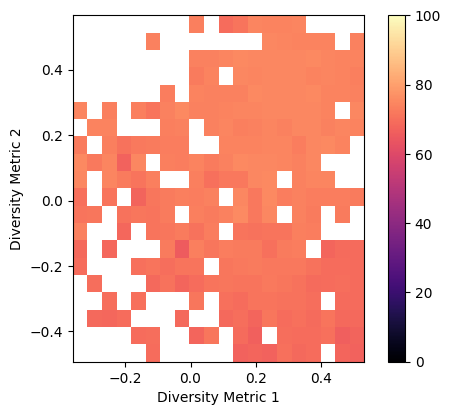

In [13]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(6, 4.5))
grid_archive_heatmap(archive, aspect="equal", vmin=0, vmax=100)
plt.xlabel("Diversity Metric 1")
plt.ylabel("Diversity Metric 2")

### Visualizing the Results

Now let's view the images from across the archive generated by QDHF. We randomly sample images in the grid with measures spread across the diversity dimensions. 

In [14]:
import itertools

# Modify this to determine how many images to plot along each dimension.
img_freq = (
    4,  # Number of columns of images.
    4,  # Number of rows of images.
)

# List of images.
imgs = []

# Convert archive to a df with solutions available.
df = archive.data(return_type="pandas")

# Compute the min and max measures for which solutions were found.
measure_bounds = np.array(
    [
        (df["measures_0"].min(), df["measures_0"].max()),
        (df["measures_1"].min(), df["measures_1"].max()),
    ]
)

archive_bounds = np.array(
    [archive.boundaries[0][[0, -1]], archive.boundaries[1][[0, -1]]]
)


delta_measures_0 = (archive_bounds[0][1] - archive_bounds[0][0]) / img_freq[0]
delta_measures_1 = (archive_bounds[1][1] - archive_bounds[1][0]) / img_freq[1]


for col, row in itertools.product(range(img_freq[1]), range(img_freq[0])):
    # Compute bounds of a box in measure space.
    measures_0_low = archive_bounds[0][0] + delta_measures_0 * row
    measures_0_high = archive_bounds[0][0] + delta_measures_0 * (row + 1)
    measures_1_low = archive_bounds[1][0] + delta_measures_1 * col
    measures_1_high = archive_bounds[1][0] + delta_measures_1 * (col + 1)

    if row == 0:
        measures_0_low = measure_bounds[0][0]
    if col == 0:
        measures_1_low = measure_bounds[1][0]
    if row == img_freq[0] - 1:
        measures_0_high = measure_bounds[0][1]
    if col == img_freq[1] - 1:
        measures_0_high = measure_bounds[1][1]

    # Query for a solution with measures within this box.
    query_string = (
        f"{measures_0_low} <= measures_0 & measures_0 <= {measures_0_high} & "
        f"{measures_1_low} <= measures_1 & measures_1 <= {measures_1_high}"
    )
    df_box = df.query(query_string)

    if not df_box.empty:
        # Randomly sample a solution from the box.
        # Stable Diffusion solutions have SD_IN_CHANNELS * SD_IN_HEIGHT * SD_IN_WIDTH 
        # dimensions, so the final solution col is solution_(x-1).
        sol = (
            df_box.loc[
                :,
                "solution_0" : "solution_{}".format(
                    SD_IN_CHANNELS * SD_IN_HEIGHT * SD_IN_WIDTH - 1
                ),
            ]
            .sample(n=1)
            .iloc[0]
        )

        # Convert the latent vector solution to an image.
        latents = torch.tensor(sol.to_numpy()).reshape(
            (1, SD_IN_CHANNELS, SD_IN_HEIGHT, SD_IN_WIDTH)
        )
        latents = latents.to(TORCH_DTYPE).to(DEVICE)
        img = SDPIPE(
            prompt,
            num_images_per_prompt=1,
            latents=latents,
            # num_inference_steps=1,  # for testing
        ).images[0]

        img = torch.from_numpy(np.array(img)).permute(2, 0, 1) / 255.0
        imgs.append(img)
    else:
        imgs.append(torch.zeros((3, IMG_HEIGHT, IMG_WIDTH)))

And the images are plotted below as a single collage.

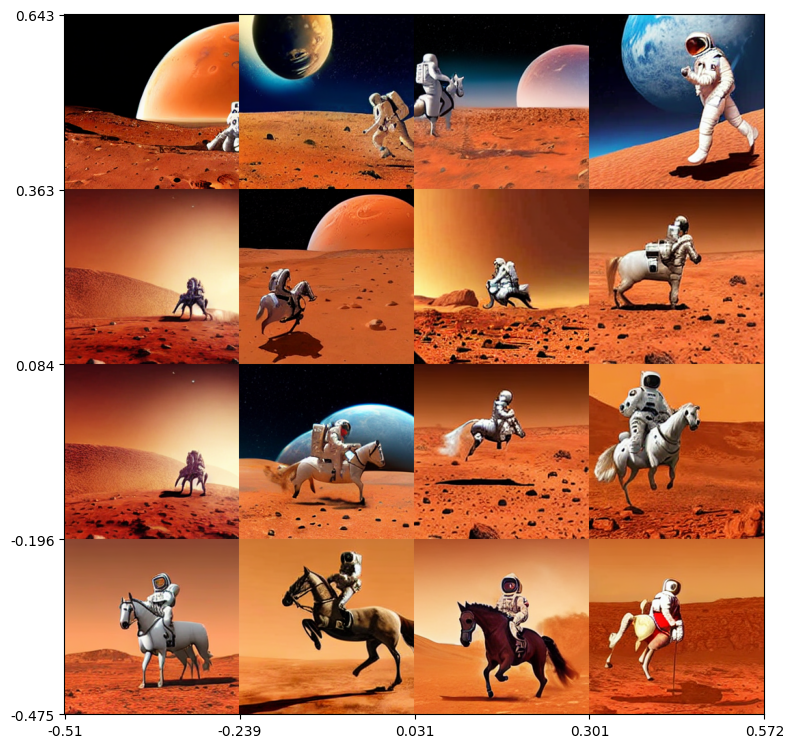

In [15]:
from torchvision.utils import make_grid


def create_archive_tick_labels(measure_range, num_ticks):
    delta = (measure_range[1] - measure_range[0]) / num_ticks
    ticklabels = [round(delta * p + measure_range[0], 3) for p in range(num_ticks + 1)]
    return ticklabels


plt.figure(figsize=(img_freq[0] * 2, img_freq[0] * 2))
img_grid = make_grid(imgs, nrow=img_freq[0], padding=0)
img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))
plt.imshow(img_grid)

plt.xlabel("")
num_x_ticks = img_freq[0]
x_ticklabels = create_archive_tick_labels(measure_bounds[0], num_x_ticks)
x_tick_range = img_grid.shape[1]
x_ticks = np.arange(0, x_tick_range + 1e-9, step=x_tick_range / num_x_ticks)
plt.xticks(x_ticks, x_ticklabels)

plt.ylabel("")
num_y_ticks = img_freq[1]
y_ticklabels = create_archive_tick_labels(measure_bounds[1], num_y_ticks)
y_ticklabels.reverse()
y_tick_range = img_grid.shape[0]
y_ticks = np.arange(0, y_tick_range + 1e-9, step=y_tick_range / num_y_ticks)
plt.yticks(y_ticks, y_ticklabels)

plt.tight_layout()

We can see that there are some visible trends of diversity such as object size (smaller on upper left, larger on bottom right), scene layout (dark sky on the top, dusty sky on the bottom), etc. 


*This tutorial uses light-weight models and smaller batch sizes for faster inference. You should get better results using the [official implementation of QDHF](https://github.com/ld-ing/qdhf).*

## Conclusion

In this tutorial, we explored using the QDHF algorithm to generate diverse images given the text prompt. We showed how QDHF can be implemented using pyribs, and how we use it in a pipeline with Stable Diffusion. The generated images show variations and visible trends of diversity without the need to manually specify diversity metrics.


## Citation

If you find this tutorial useful, please cite our paper:

```text
@article{ding2023quality,
  title={Quality Diversity through Human Feedback},
  author={Ding, Li and Zhang, Jenny and Clune, Jeff and Spector, Lee and Lehman, Joel},
  journal={arXiv preprint arXiv:2310.12103},
  year={2023}
}
```